In [1]:
import torch
import numpy as np
import matplotlib.pyplot as plt
import librosa, librosa.display
import IPython.display as ipd

%matplotlib notebook

def exp_chirp(duration=2, sr=2**14, f0=110, gamma=0.5):
    t = torch.arange(0, duration, 1/sr)
    phi = f0 / (gamma*np.log(2)) * (2 ** (gamma*t) - 1)
    return torch.sin(2*np.pi*phi)


def sinusoid(duration=2, sr=2**14, f0=110):
    t = torch.arange(0, duration, 1/sr)
    return torch.sin(2 * np.pi * f0 * t)


def generate(f_c, f_m, gamma=0.5, duration=2, sr=2**14):
    x_c = exp_chirp(duration=duration, sr=sr, gamma=gamma, f0=f_c) # carrier chirp
    x_m = sinusoid(duration, sr=sr, f0=f_m)
    x = x_c * x_m * torch.hann_window(duration * sr)
    return x


def plot(x, sr=2**14):
    fig, axes = plt.subplots(2, 1, figsize=(8, 8))
    librosa.display.waveshow(x.numpy(), sr=sr, ax=axes[0])
    axes[0].set_title("Waveplot of the signal")
    hop_length=256
    C = librosa.cqt(
        x.numpy(),
        fmin=55, bins_per_octave=12, n_bins=72, sr=sr, hop_length=hop_length)
    librosa.display.specshow(
        librosa.amplitude_to_db(np.abs(C)),
        x_axis="time", sr=sr, hop_length=hop_length,
        y_axis="cqt_hz", bins_per_octave=12,
        ax=axes[1])
    axes[1].set_title("Time-Frequency Spectrogram of the signal")
    fig.tight_layout()
    
def disp_audio(x, rate=2**14):
    return ipd.Audio(x, rate=rate, autoplay=True)

## Amplitude-modulated Chirp Synthesis

<IPython.core.display.Javascript object>


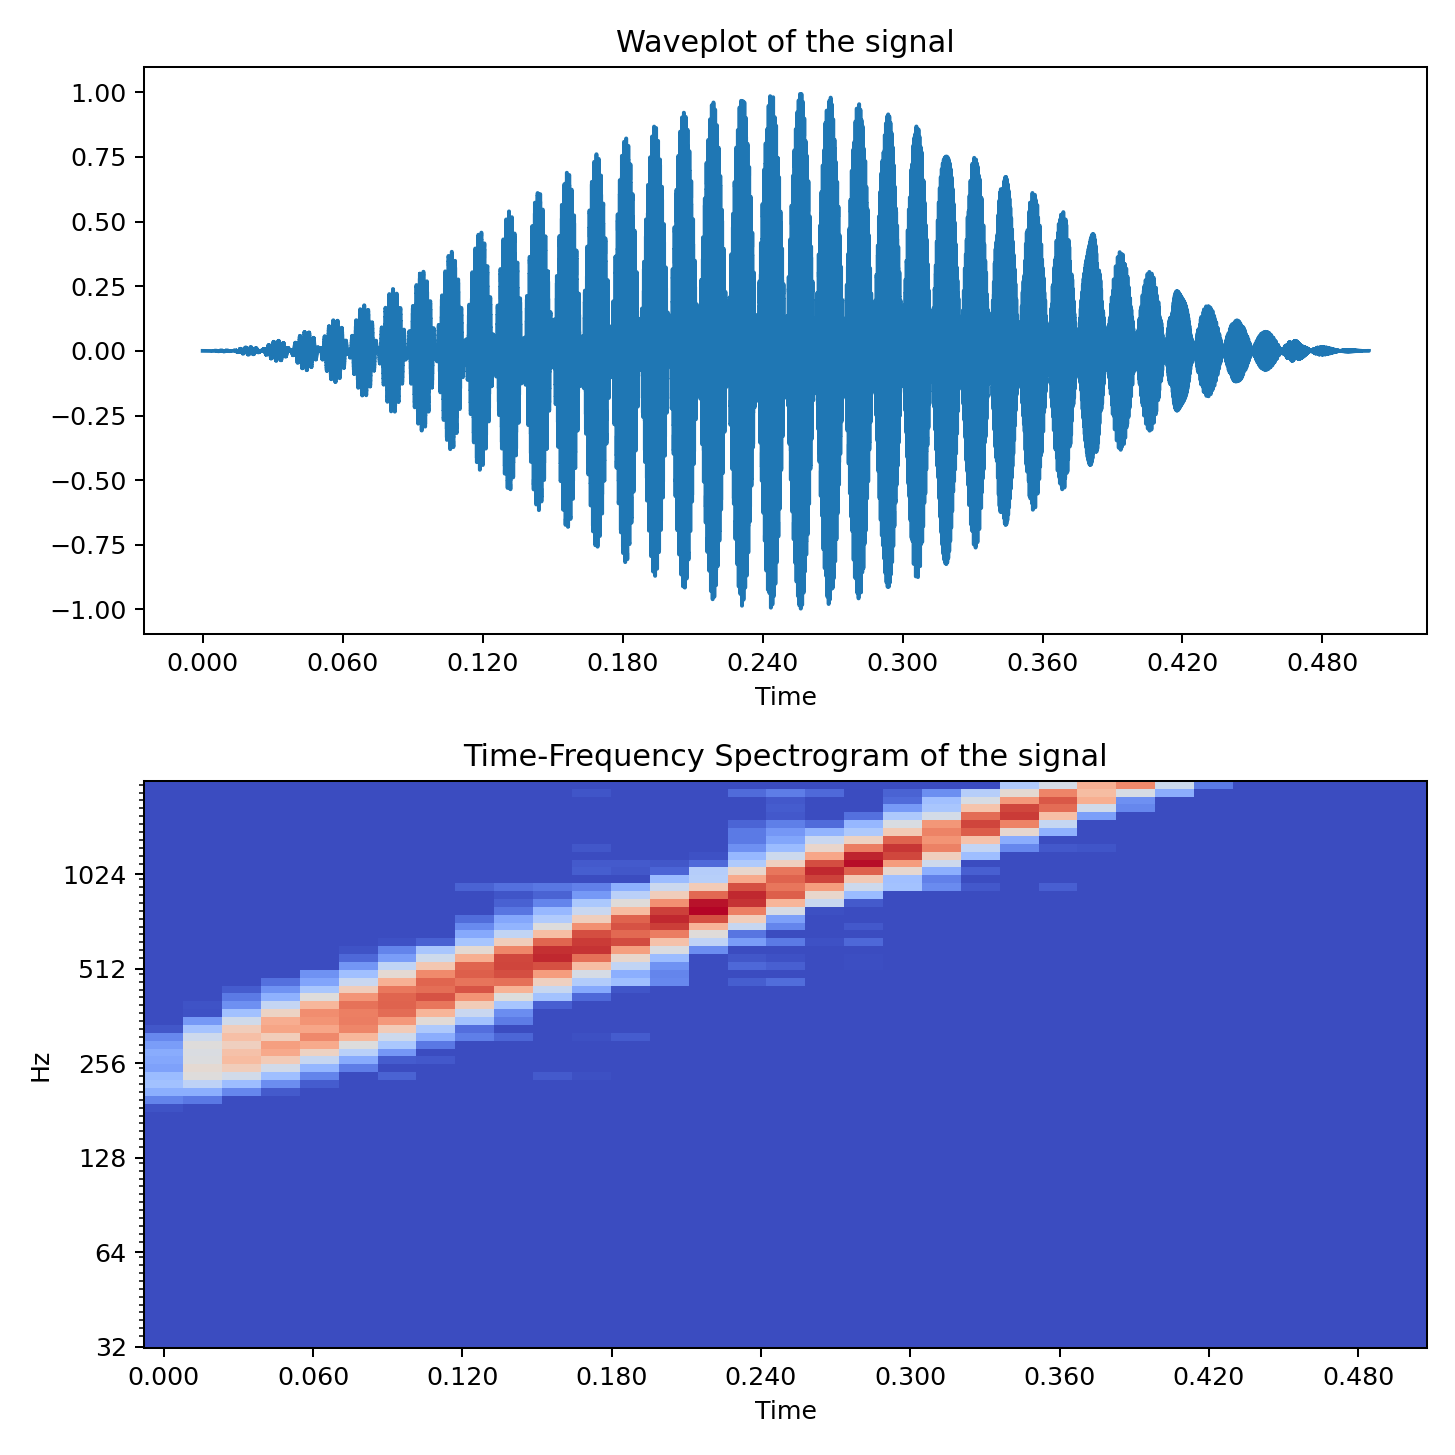

In [2]:
x = generate(f_c=200, f_m=20, gamma=4, duration=1, sr=2**13)
plot(x)
disp_audio(x)

In [4]:
import tqdm

f0s = np.logspace(np.log10(100), np.log10(200), 16)
fms = np.logspace(np.log10(4), np.log10(32), 16)
gammas = np.logspace(np.log10(0.5), np.log10(4), 16)

duration, sr = 1, 2**13

audio = torch.zeros(len(f0s), len(fms), len(gammas), duration * sr)
cmap = torch.zeros(3, len(f0s) * len(fms) * len(gammas))
c = 0
for i, f0 in tqdm.tqdm(enumerate(f0s)):
    for j, fm in enumerate(fms):
        for k, gamma in enumerate(gammas):
            audio[i, j, k] = generate(f0, fm, gamma, sr=sr, duration=duration)
            cmap[0, c], cmap[1, c], cmap[2, c] = f0, fm, gamma
            c += 1
            
X = audio.view(-1, audio.shape[-1])

16it [00:01,  8.47it/s]


## Joint Time-Frequency Scattering

In [20]:
from kymatio.torch import TimeFrequencyScattering1D
import time

N = duration * sr

jtfs = TimeFrequencyScattering1D(
    shape=(N, ),
    T=N,
    Q=8,
    J=12,
    max_pad_factor=1, 
    max_pad_factor_fr=1).cuda()

In [21]:
n_samples = X.shape[0]
n_paths = jtfs(X[0]).shape[1]
sx = torch.zeros(n_samples, n_paths)

for i in tqdm.tqdm(range(n_samples)):
    sx[i, :] = jtfs(X[i, :])[:, :, 0]

100%|██████████████████████████████████████████████████████████████████████████████████| 4096/4096 [09:58<00:00,  6.84it/s]


0.2144489288330078


<IPython.core.display.Javascript object>


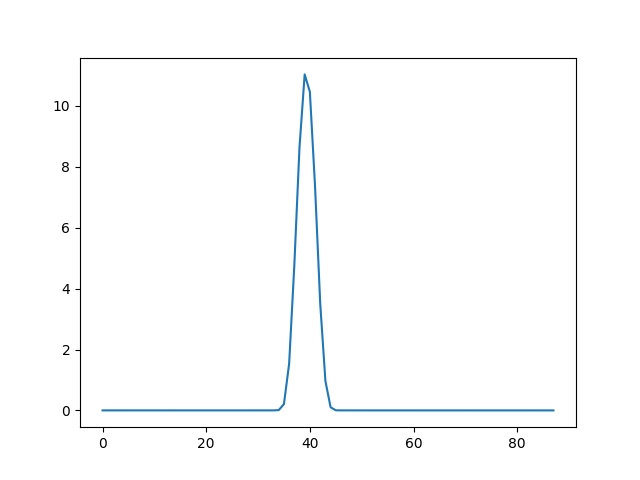

In [26]:
%matplotlib notebook
start = time.time()

sx = jtfs(X[0, :].cuda())
print(time.time() - start)
plt.plot(sx[0].cpu().numpy().ravel())

In [58]:
jtfs.meta()[1]["xi"].shape

(198, 11, 3)

### Manifold embedding of the nearest neighbour graph

In [24]:
def plot_isomap(Y, cmap):
    fig = plt.figure(figsize=plt.figaspect(0.5))
    ax = fig.add_subplot(1, 3, 1, projection='3d')
    ax.scatter3D(Y[:, 0], Y[:, 1], Y[:, 2], c=cmap[0], cmap='bwr');
    
    ax.set_xticklabels([])
    ax.set_yticklabels([])
    ax.set_zticklabels([])
    
    # f modulator
    ax = fig.add_subplot(1, 3, 2, projection='3d')
    ax.scatter3D(Y[:, 0], Y[:, 1], Y[:, 2], c=cmap[1], cmap='bwr');
    ax.set_xticklabels([])
    ax.set_yticklabels([])
    ax.set_zticklabels([])

    # chirp rate
    ax = fig.add_subplot(1, 3, 3, projection='3d')
    ax.scatter3D(Y[:, 0], Y[:, 1], Y[:, 2], c=cmap[2], cmap='bwr');
    ax.set_xticklabels([])
    ax.set_yticklabels([])
    ax.set_zticklabels([])

<IPython.core.display.Javascript object>


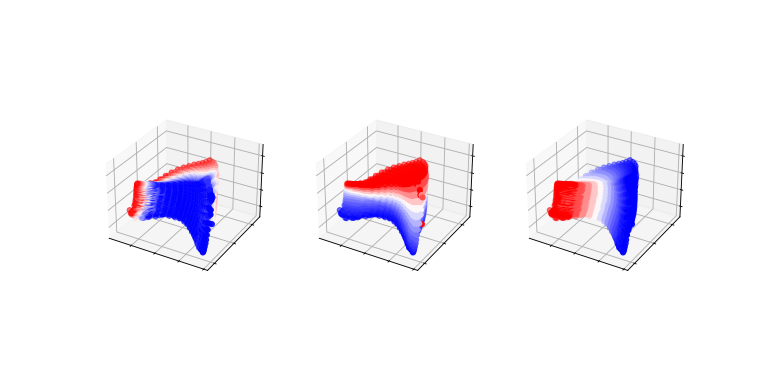

In [26]:
from sklearn.manifold import Isomap

embedding = Isomap(n_components=3, n_neighbors=40)
Y = embedding.fit_transform(sx)
plot_isomap(Y, cmap)

## Open-L3

In [ ]:
import openl3
X_ol3, _ = openl3.get_audio_embedding(
    list(X.numpy()), 
    sr, 
    batch_size=32,
    frontend='kapre',
    content_type='music')

2022-02-12 10:20:17.595005: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudnn.so.8'; dlerror: libcudnn.so.8: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /import/linux/cuda/11.5/lib64:/usr/local/cuda-10.2/lib64:/import/linux/python/3.6.6/lib:/usr/local/cuda/lib64/:/usr/local/cuda-10.0/lib64
2022-02-12 10:20:17.595070: W tensorflow/core/common_runtime/gpu/gpu_device.cc:1850] Cannot dlopen some GPU libraries. Please make sure the missing libraries mentioned above are installed properly if you would like to use GPU. Follow the guide at https://www.tensorflow.org/install/gpu for how to download and setup the required libraries for your platform.
Skipping registering GPU devices...
2022-02-12 10:20:17.595697: I tensorflow/core/platform/cpu_feature_guard.cc:151] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical 

644/768 [========================>.....] - ETA: 6:30

### Manifold embedding of the nearest neighbour graph

In [3]:
X_ol3 = np.load('/homes/cv300/Documents/scattering/data/openl3.npy')
cmap = np.load('/homes/cv300/Documents/scattering/data/cmap.npy')

embedding = Isomap(n_components=3, n_neighbors=40)
Y = embedding.fit_transform(X_ol3)
plot_isomap(Y, cmap.T)

/homes/cv300/venvs/dafx/lib/python3.8/site-packages/sklearn/manifold/_isomap.py:324: UserWarning: The number of connected components of the neighbors graph is 4 > 1. Completing the graph to fit Isomap might be slow. Increase the number of neighbors to avoid this issue.
  self._fit_transform(X)
/homes/cv300/venvs/dafx/lib/python3.8/site-packages/scipy/sparse/_index.py:103: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_intXint(row, col, x.flat[0])
/homes/cv300/venvs/dafx/lib/python3.8/site-packages/scipy/sparse/_index.py:103: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_intXint(row, col, x.flat[0])
/homes/cv300/venvs/dafx/lib/python3.8/site-packages/scipy/sparse/_index.py:103: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_intXint(row, col, x.

In [30]:
for i in range(sx.shape[0]):
    np.save(f'/homes/cv300/Documents/scattering/data/jtfs/{i}', sx[i])
    np.save(f'/homes/cv300/Documents/scattering/data/theta/{i}', cmap.T[i])